# Grad-CAM

在深度学习中，我们经常需要查看或修改模型中间层的输出或梯度。然而，标准的前向传播和反向传播过程通常是一个黑盒，我们很难直接访问中间层的信息。PyTorch 提供了一种强大的工具——hook 函数，它允许我们在不修改模型结构的情况下，获取或修改中间层的信息。它的核心价值在于让开发者能够动态监听、捕获甚至修改模型内部任意层的输入 / 输出或梯度，而无需修改模型的原始代码结构。
常用场景如下：
1. 调试与可视化中间层输出
2. 特征提取：如在图像分类模型中提取高层语义特征用于下游任务
3. 梯度分析与修改： 在训练过程中，对某些层进行梯度裁剪或缩放，以改变模型训练的动态
4. 模型压缩：在推理阶段对特定层的输出应用掩码（如剪枝后的模型权重掩码），实现轻量化推理。


我们之前介绍过机器学习可解释性工具，例如 SHAP、PDPBox 等，这些工具在处理结构化数据时，能够有效揭示模型内部的决策逻辑。而在深度学习领域，同样存在一系列方法来解析模型的决策过程：以图像分类任务为例，我们不仅可以通过可视化特征图，直观观察不同层对图像特征的提取程度；还能进一步借助 Grad-CAM 等技术生成特征热力图，清晰展现模型在预测过程中对图像不同区域的关注重点，从而深入理解其决策机制。
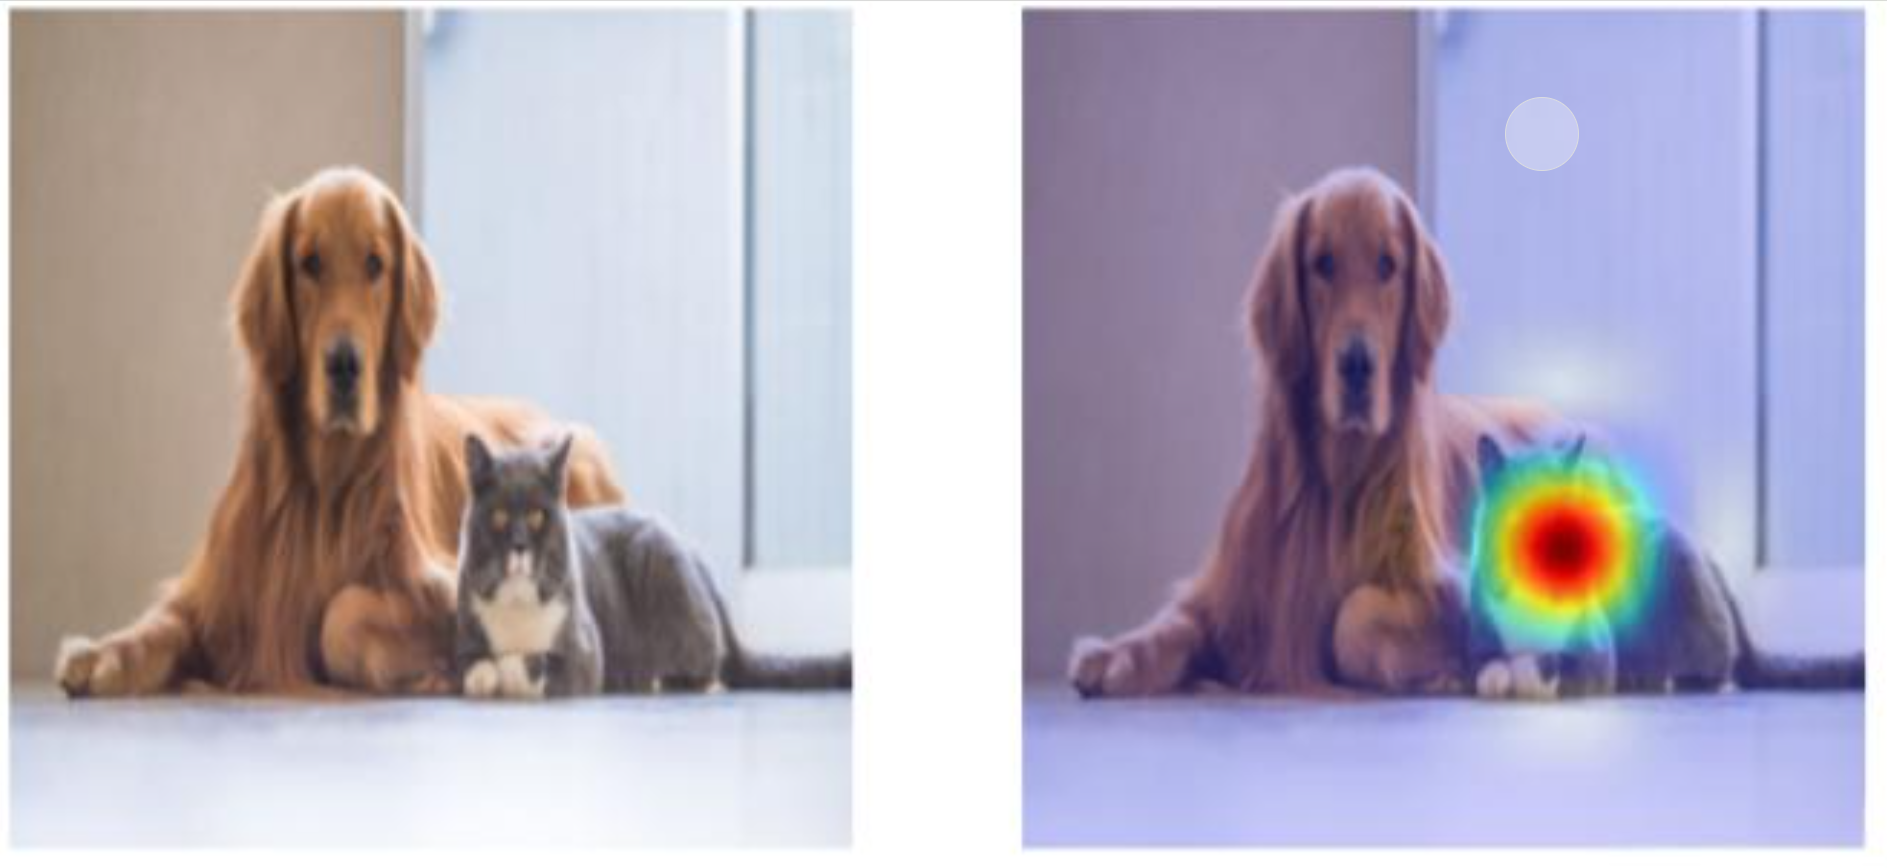
比如上图，对猫这个类别做特征热力图，可以看到模型对于猫关注的区域

更进一步，如下图判断是否是护士，通过性别判断，这是有偏见的
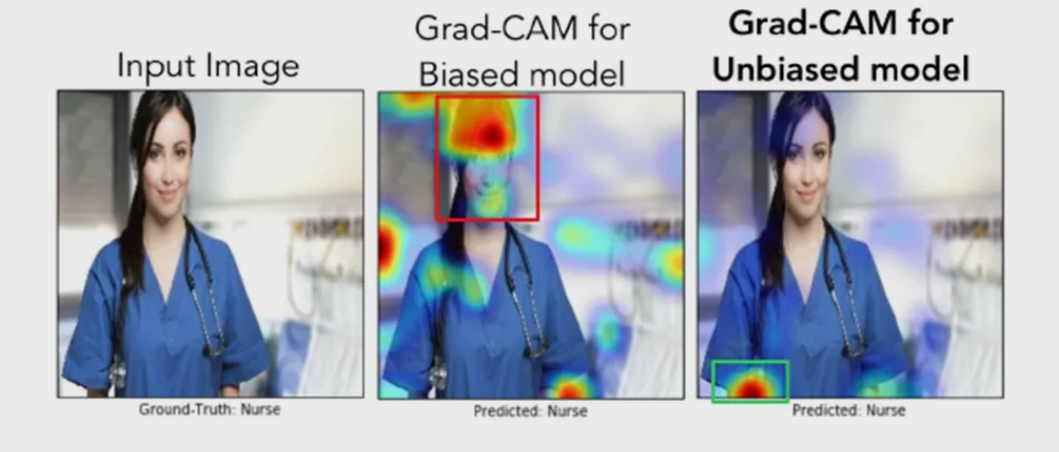
应该修改样本数让男性和女性数目相等，避免有偏见的模型

## 一、 前置知识

### 1.1 回调函数

Hook本质是回调函数，所以我们先介绍一下回调函数

回调函数是作为参数传递给其他函数的函数，其目的是在某个特定事件发生时被调用执行。这种机制允许代码在运行时动态指定需要执行的逻辑，实现了代码的灵活性和可扩展性。
回调函数的核心价值在于：

1. 解耦逻辑：将通用逻辑与特定处理逻辑分离，使代码更模块化。
2. 事件驱动编程：在异步操作、事件监听（如点击按钮、网络请求完成）等场景中广泛应用。
3. 延迟执行：允许在未来某个时间点执行特定代码，而不必立即执行。

其中回调函数作为参数传入，所以在定义的时候一般用callback来命名，在 PyTorch 的 Hook API 中，回调参数通常命名为 hook

In [47]:
# 定义一个回调函数
def handle_result(result):
    """处理计算结果的回调函数"""
    print(f"计算结果是: {result}")

# 定义一个接受回调函数的函数
def calculate(a, b, callback): # callback是一个约定俗成的参数名
    """
    这个函数接受两个数值和一个回调函数，用于处理计算结果。
    执行计算并调用回调函数
    """
    result = a + b
    callback(result)  # 在计算完成后调用回调函数

# 使用回调函数
calculate(3, 5, handle_result)  # 输出: 计算结果是: 8

计算结果是: 8


是不是看上去很类似于装饰器的写法，我们回顾下装饰器

In [48]:
def handle_result(result):
    """处理计算结果的回调函数"""
    print(f"计算结果是: {result}")

def with_callback(callback):
    """装饰器工厂：创建一个将计算结果传递给回调函数的装饰器"""
    def decorator(func):
        """实际的装饰器，用于包装目标函数"""
        def wrapper(a, b):
            """被装饰后的函数，执行计算并调用回调"""
            result = func(a, b)  # 执行原始计算
            callback(result)     # 调用回调函数处理结果
            return result        # 返回计算结果（可选）
        return wrapper
    return decorator

# 使用装饰器包装原始计算函数
@with_callback(handle_result)
def calculate(a, b):
    """执行加法计算"""
    return a + b

# 直接调用被装饰后的函数
calculate(3, 5)  # 输出: 计算结果是: 8

计算结果是: 8


8

回调函数核心是将处理逻辑（回调）作为参数传递给计算函数，控制流：计算函数 → 回调函数，适合一次性或动态的处理需求（控制流指的是程序执行时各代码块的执行顺序）

装饰器实现核心是修改原始函数的行为，在其基础上添加额外功能，控制流：被装饰函数 → 原始计算 → 回调函数，适合统一的、可复用的处理逻辑

两种实现方式都达到了相同的效果，但装饰器提供了更优雅的语法和更好的代码复用性。在需要对多个计算函数应用相同回调逻辑时，装饰器方案会更加高效。






关键区别：回调 vs 装饰器
| **对比维度**       | **回调函数**                          | **装饰器**                          |
|--------------------|---------------------------------------|-------------------------------------|
| **本质**           | 作为参数传递的普通函数                | 用于包装函数的高阶函数              |
| **目标**           | 在特定时机执行“下游任务”              | 修改原函数的行为（增强功能）        |
| **控制权**         | 由外层函数决定何时调用                | 由装饰器主动修改原函数的执行流程    |
| **代码结构**       | 外层函数调用回调（单向调用）          | 装饰器返回新函数替代原函数（嵌套调用）|
| **常见场景**       | 异步任务（如网络请求、文件读写的回调）| 权限校验、日志记录、性能监控等      |


**总结：从回调到装饰器的思维升级**
1. **回调函数**是“**被动响应**”的工具，核心是“传递函数作为参数，等待触发”。  
2. **装饰器**是“**主动改造**”的工具，核心是“用新函数包装原函数，修改行为”。  
3. **Hook 函数**是两者的灵活结合，既可以通过回调参数实现（如 PyTorch），也可以通过装饰器机制实现（如某些框架的生命周期钩子）。  

Hook 的底层工作原理
PyTorch 的 Hook 机制基于其**动态计算图**系统：
1. 当你注册一个 Hook 时，PyTorch 会在计算图的特定节点（如模块或张量）上添加一个回调函数。
2. 当计算图执行到该节点时（前向或反向传播），自动触发对应的 Hook 函数。
3. Hook 函数可以访问或修改流经该节点的数据（如输入、输出或梯度）。

这种设计使得 Hook 能够在不干扰模型正常运行的前提下，灵活地插入自定义逻辑。

理解这两个概念后，再学习 Hook 会更轻松——Hook 本质是在程序流程中预留的“可插入点”，而插入的方式可以是回调函数、装饰器或其他形式。



### 1.2 lamda匿名函数



在hook中常常用到lambda函数，它是一种匿名函数（没有正式名称的函数），最大特点是用完即弃，无需提前命名和定义。它的语法形式非常简约，仅需一行即可完成定义，格式如下：
lambda 参数列表: 表达式

- 参数列表：可以是单个参数、多个参数或无参数。

- 表达式：函数的返回值（无需 return 语句，表达式结果直接返回）。

In [49]:
# 定义匿名函数：计算平方
square = lambda x: x ** 2

# 调用
print(square(5))  # 输出: 25

25


这种形式很简约，只需要一行就可以定义一个函数，lambda 的核心价值在于用极简语法快速定义临时函数，避免为一次性使用的简单逻辑单独命名函数，从而减少代码冗余，提升开发效率。

**与普通函数的对比**  
| **特性**         | **`lambda` 函数**                | **普通函数（`def`）**          |  
|------------------|----------------------------------|--------------------------------|  
| **定义方式**     | 一行表达式，无需 `def` 和名称    | 需要 `def` 关键字和函数名      |  
| **复杂度**       | 仅限单行表达式，逻辑简单         | 可包含多行代码、条件、循环等   |  
| **复用性**       | 通常用于单次或临时场景           | 可重复调用，适合复用逻辑       |  
| **可读性**       | 适合简短逻辑（过度使用可能晦涩） | 函数名可清晰表达用途，可读性强 |  



## 二、 hook函数

Hook 函数是一种回调函数，它可以在不干扰模型正常计算流程的情况下，插入到模型的特定位置，以便获取或修改中间层的输出或梯度。PyTorch 提供了两种主要的 hook：

1. **Module Hooks**：用于监听整个模块的输入和输出
2. **Tensor Hooks**：用于监听张量的梯度

下面我们将通过具体的例子来学习这两种 hook 的使用方法。

In [50]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子，保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

### 2.1 模块钩子 (Module Hooks)

模块钩子允许我们在模块的输入或输出经过时进行监听。PyTorch 提供了两种模块钩子：

- `register_forward_hook`：在前向传播时监听模块的输入和输出
- `register_backward_hook`：在反向传播时监听模块的输入梯度和输出梯度

####  2.1.1 前向钩子 (Forward Hook)

前向钩子是一个函数，它会在模块的前向传播完成后立即被调用。这个函数可以访问模块的输入和输出，但不能修改它们。让我们通过一个简单的例子来理解前向钩子的工作原理。

In [51]:
import torch
import torch.nn as nn

# 定义一个简单的卷积神经网络模型
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        # 定义卷积层：输入通道1，输出通道2，卷积核3x3，填充1保持尺寸不变
        self.conv = nn.Conv2d(1, 2, kernel_size=3, padding=1)
        # 定义ReLU激活函数
        self.relu = nn.ReLU()
        # 定义全连接层：输入特征2*4*4，输出10分类
        self.fc = nn.Linear(2 * 4 * 4, 10)

    def forward(self, x):
        # 卷积操作
        x = self.conv(x)
        # 激活函数
        x = self.relu(x)
        # 展平为一维向量，准备输入全连接层
        x = x.view(-1, 2 * 4 * 4)
        # 全连接分类
        x = self.fc(x)
        return x

# 创建模型实例
model = SimpleModel()

# 创建一个列表用于存储中间层的输出
conv_outputs = []

# 定义前向钩子函数 - 用于在模型前向传播过程中获取中间层信息
def forward_hook(module, input, output):
    """
    前向钩子函数，会在模块每次执行前向传播后被自动调用
    
    参数:
        module: 当前应用钩子的模块实例
        input: 传递给该模块的输入张量元组
        output: 该模块产生的输出张量
    """
    print(f"钩子被调用！模块类型: {type(module)}")
    print(f"输入形状: {input[0].shape}") #  input是一个元组，对应 (image, label)
    print(f"输出形状: {output.shape}")
    
    # 保存卷积层的输出用于后续分析
    # 使用detach()避免追踪梯度，防止内存泄漏
    conv_outputs.append(output.detach())

# 在卷积层注册前向钩子
# register_forward_hook返回一个句柄，用于后续移除钩子
hook_handle = model.conv.register_forward_hook(forward_hook)

# 创建一个随机输入张量 (批次大小=1, 通道=1, 高度=4, 宽度=4)
x = torch.randn(1, 1, 4, 4)

# 执行前向传播 - 此时会自动触发钩子函数
output = model(x)

# 释放钩子 - 重要！防止在后续模型使用中持续调用钩子造成意外行为或内存泄漏
hook_handle.remove()

# # 打印中间层输出结果
# if conv_outputs:
#     print(f"\n卷积层输出形状: {conv_outputs[0].shape}")
#     print(f"卷积层输出值示例: {conv_outputs[0][0, 0, :, :]}")

钩子被调用！模块类型: <class 'torch.nn.modules.conv.Conv2d'>
输入形状: torch.Size([1, 1, 4, 4])
输出形状: torch.Size([1, 2, 4, 4])


在上面的例子中，我们定义了一个简单的模型，包含卷积层、ReLU激活函数和全连接层。然后，我们在卷积层上注册了一个前向钩子。当前向传播执行到卷积层时，钩子函数会被自动调用。

钩子函数接收三个参数：
- `module`：应用钩子的模块实例
- `input`：传递给模块的输入（可能包含多个张量）
- `output`：模块的输出

我们可以在钩子函数中查看或记录这些信息，但不能直接修改它们。如果需要修改输出，可以使用 `register_forward_pre_hook` 或 `register_forward_hook_with_kwargs`（PyTorch 1.9+）。

最后，我们使用 `hook_handle.remove()` 释放了钩子，这一点很重要，因为未释放的钩子可能会导致内存泄漏。

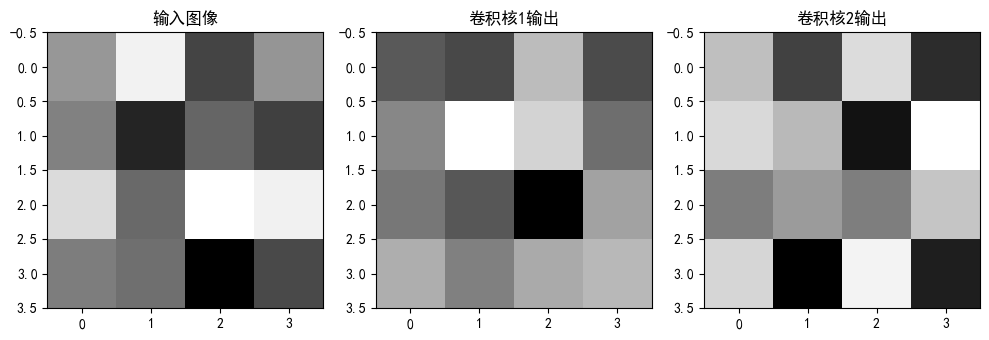

In [52]:
# 让我们可视化卷积层的输出
if conv_outputs:
    plt.figure(figsize=(10, 5))
    
    # 原始输入图像
    plt.subplot(1, 3, 1)
    plt.title('输入图像')
    plt.imshow(x[0, 0].detach().numpy(), cmap='gray') # 显示灰度图像
    
    # 第一个卷积核的输出
    plt.subplot(1, 3, 2)
    plt.title('卷积核1输出')
    plt.imshow(conv_outputs[0][0, 0].detach().numpy(), cmap='gray')
    
    # 第二个卷积核的输出
    plt.subplot(1, 3, 3)
    plt.title('卷积核2输出')
    plt.imshow(conv_outputs[0][0, 1].detach().numpy(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

#### 2.1.2 反向钩子 (Backward Hook)

反向钩子与前向钩子类似，但它是在反向传播过程中被调用的。反向钩子可以用来获取或修改梯度信息。

In [53]:
# 定义一个存储梯度的列表
conv_gradients = []

# 定义反向钩子函数
def backward_hook(module, grad_input, grad_output):
    # 模块：当前应用钩子的模块
    # grad_input：模块输入的梯度
    # grad_output：模块输出的梯度
    print(f"反向钩子被调用！模块类型: {type(module)}")
    print(f"输入梯度数量: {len(grad_input)}")
    print(f"输出梯度数量: {len(grad_output)}")
    
    # 保存梯度供后续分析
    conv_gradients.append((grad_input, grad_output))

# 在卷积层注册反向钩子
hook_handle = model.conv.register_backward_hook(backward_hook)

# 创建一个随机输入并进行前向传播
x = torch.randn(1, 1, 4, 4, requires_grad=True)
output = model(x)

# 定义一个简单的损失函数并进行反向传播
loss = output.sum()
loss.backward()

# 释放钩子
hook_handle.remove()

反向钩子被调用！模块类型: <class 'torch.nn.modules.conv.Conv2d'>
输入梯度数量: 3
输出梯度数量: 1


### 2.2 张量钩子 (Tensor Hooks)

除了模块钩子，PyTorch 还提供了张量钩子，允许我们直接监听和修改张量的梯度。张量钩子有两种：

- `register_hook`：用于监听张量的梯度
- `register_full_backward_hook`：用于在完整的反向传播过程中监听张量的梯度（PyTorch 1.4+）



In [54]:
# 创建一个需要计算梯度的张量
x = torch.tensor([2.0], requires_grad=True)
y = x ** 2
z = y ** 3

# 定义一个钩子函数，用于修改梯度
def tensor_hook(grad):
    print(f"原始梯度: {grad}")
    # 修改梯度，例如将梯度减半
    return grad / 2

# 在y上注册钩子
hook_handle = y.register_hook(tensor_hook)

# 计算梯度
z.backward()

print(f"x的梯度: {x.grad}")

# 释放钩子
hook_handle.remove()

原始梯度: tensor([48.])
x的梯度: tensor([96.])




在这个例子中，我们创建了一个计算图 `z = (x^2)^3`。然后在中间变量 `y` 上注册了一个钩子。当调用 `z.backward()` 时，梯度会从 `z` 反向传播到 `x`。在传播过程中，钩子函数会被调用，我们可以在钩子函数中查看或修改梯度。

在这个例子中，我们将梯度减半，因此最终 `x` 的梯度是原始梯度的一半。

## 三、 Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) 算法是一种强大的可视化技术，用于解释卷积神经网络 (CNN) 的决策过程。它通过计算特征图的梯度来生成类激活映射（Class Activation Mapping，简称 CAM ），直观地显示图像中哪些区域对模型的特定预测贡献最大。

Grad-CAM 的核心思想是：通过反向传播得到的梯度信息，来衡量每个特征图对目标类别的重要性。

1. 梯度信息：通过计算目标类别对特征图的梯度，得到每个特征图的重要性权重。
2. 特征加权：用这些权重对特征图进行加权求和，得到类激活映射。
3. 可视化：将激活映射叠加到原始图像上，高亮显示对预测最关键的区域。



In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 设置随机种子确保结果可复现
# 在深度学习中，随机种子可以让每次运行代码时，模型初始化参数、数据打乱等随机操作保持一致，方便调试和对比实验结果
torch.manual_seed(42)
np.random.seed(42)

# 加载CIFAR-10数据集
# 定义数据预处理步骤，先将图像转换为张量，再进行归一化操作
# 归一化的均值和标准差是(0.5, 0.5, 0.5)，这里的均值和标准差是对CIFAR-10数据集的经验值，使得数据分布更有利于模型训练
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载测试集，指定数据集根目录为'./data'，设置为测试集（train=False），如果数据不存在则下载（download=True），并应用上述定义的预处理
testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

# 定义类别名称，CIFAR-10数据集包含这10个类别
classes = ('飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车')

# 定义一个简单的CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 第一个卷积层，输入通道为3（彩色图像），输出通道为32，卷积核大小为3x3，填充为1以保持图像尺寸不变
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # 第二个卷积层，输入通道为32，输出通道为64，卷积核大小为3x3，填充为1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 第三个卷积层，输入通道为64，输出通道为128，卷积核大小为3x3，填充为1
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # 最大池化层，池化核大小为2x2，步长为2，用于下采样，减少数据量并提取主要特征
        self.pool = nn.MaxPool2d(2, 2)
        # 第一个全连接层，输入特征数为128 * 4 * 4（经过前面卷积和池化后的特征维度），输出为512
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # 第二个全连接层，输入为512，输出为10（对应CIFAR-10的10个类别）
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # 第一个卷积层后接ReLU激活函数和最大池化操作，经过池化后图像尺寸变为原来的一半，这里输出尺寸变为16x16
        x = self.pool(F.relu(self.conv1(x)))  
        # 第二个卷积层后接ReLU激活函数和最大池化操作，输出尺寸变为8x8
        x = self.pool(F.relu(self.conv2(x)))  
        # 第三个卷积层后接ReLU激活函数和最大池化操作，输出尺寸变为4x4
        x = self.pool(F.relu(self.conv3(x)))  
        # 将特征图展平为一维向量，以便输入到全连接层
        x = x.view(-1, 128 * 4 * 4)
        # 第一个全连接层后接ReLU激活函数
        x = F.relu(self.fc1(x))
        # 第二个全连接层输出分类结果
        x = self.fc2(x)
        return x

# 初始化模型
model = SimpleCNN()
print("模型已创建")

# 如果有GPU则使用GPU，将模型转移到对应的设备上
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 训练模型（简化版，实际应用中应该进行完整训练）
def train_model(model, epochs=1):
    # 加载训练集，指定数据集根目录为'./data'，设置为训练集（train=True），如果数据不存在则下载（download=True），并应用前面定义的预处理
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True,
        download=True, 
        transform=transform
    )
    # 创建数据加载器，设置批量大小为64，打乱数据顺序（shuffle=True），使用2个线程加载数据
    trainloader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=64,
        shuffle=True, 
        num_workers=2
    )
    
    # 定义损失函数为交叉熵损失，用于分类任务
    criterion = nn.CrossEntropyLoss()
    # 定义优化器为Adam，用于更新模型参数，学习率设置为0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # 从数据加载器中获取图像和标签
            inputs, labels = data
            # 将图像和标签转移到对应的设备（GPU或CPU）上
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 清空梯度，避免梯度累加
            optimizer.zero_grad()
            # 模型前向传播得到输出
            outputs = model(inputs)
            # 计算损失
            loss = criterion(outputs, labels)
            # 反向传播计算梯度
            loss.backward()
            # 更新模型参数
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99:
                # 每100个批次打印一次平均损失
                print(f'[{epoch + 1}, {i + 1}] 损失: {running_loss / 100:.3f}')
                running_loss = 0.0
    
    print("训练完成")

# 训练模型（可选，如果有预训练模型可以加载）
# 取消下面这行的注释来训练模型
# train_model(model, epochs=1)

# 或者尝试加载预训练模型（如果存在）
try:
    # 尝试加载名为'cifar10_cnn.pth'的模型参数
    model.load_state_dict(torch.load('cifar10_cnn.pth'))
    print("已加载预训练模型")
except:
    print("无法加载预训练模型，使用未训练模型或训练新模型")
    # 如果没有预训练模型，可以在这里调用train_model函数
    train_model(model, epochs=1)
    # 保存训练后的模型参数
    torch.save(model.state_dict(), 'cifar10_cnn.pth')

# 设置模型为评估模式，此时模型中的一些操作（如dropout、batchnorm等）会切换到评估状态
model.eval()

# Grad-CAM实现
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 注册钩子，用于获取目标层的前向传播输出和反向传播梯度
        self.register_hooks()
        
    def register_hooks(self):
        # 前向钩子函数，在目标层前向传播后被调用，保存目标层的输出（激活值）
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        # 反向钩子函数，在目标层反向传播后被调用，保存目标层的梯度
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        # 在目标层注册前向钩子和反向钩子
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, target_class=None):
        # 前向传播，得到模型输出
        model_output = self.model(input_image)
        
        if target_class is None:
            # 如果未指定目标类别，则取模型预测概率最大的类别作为目标类别
            target_class = torch.argmax(model_output, dim=1).item()
        
        # 清除模型梯度，避免之前的梯度影响
        self.model.zero_grad()
        
        # 反向传播，构造one-hot向量，使得目标类别对应的梯度为1，其余为0，然后进行反向传播计算梯度
        one_hot = torch.zeros_like(model_output)
        one_hot[0, target_class] = 1
        model_output.backward(gradient=one_hot)
        
        # 获取之前保存的目标层的梯度和激活值
        gradients = self.gradients
        activations = self.activations
        
        # 对梯度进行全局平均池化，得到每个通道的权重，用于衡量每个通道的重要性
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        
        # 加权激活映射，将权重与激活值相乘并求和，得到类激活映射的初步结果
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        
        # ReLU激活，只保留对目标类别有正贡献的区域，去除负贡献的影响
        cam = F.relu(cam)
        
        # 调整大小并归一化，将类激活映射调整为与输入图像相同的尺寸（32x32），并归一化到[0, 1]范围
        cam = F.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max() if cam.max() > 0 else cam
        
        return cam.cpu().squeeze().numpy(), target_class

Files already downloaded and verified
模型已创建
已加载预训练模型


选择的图像类别: 青蛙


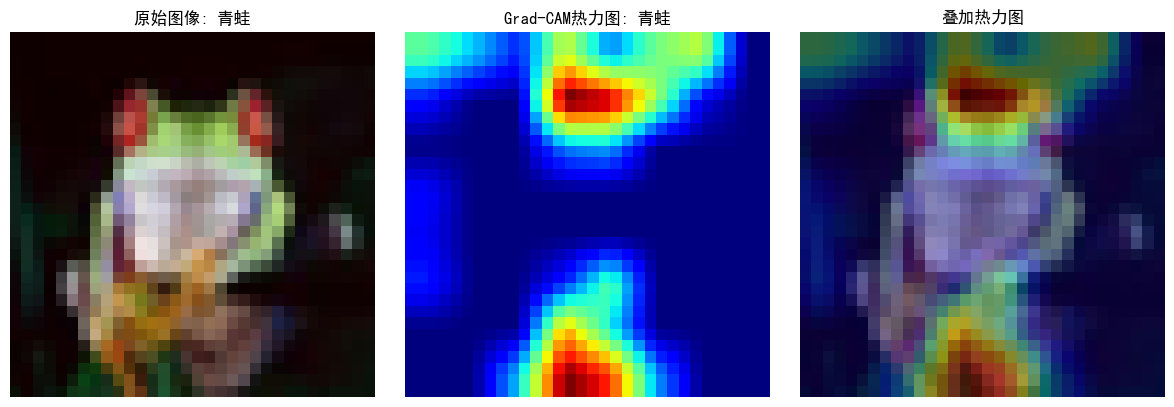

In [56]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 选择一个随机图像
# idx = np.random.randint(len(testset))
idx = 102  # 选择测试集中的第101张图片 (索引从0开始)
image, label = testset[idx]
print(f"选择的图像类别: {classes[label]}")

# 转换图像以便可视化
def tensor_to_np(tensor):
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# 添加批次维度并移动到设备
input_tensor = image.unsqueeze(0).to(device)

# 初始化Grad-CAM（选择最后一个卷积层）
grad_cam = GradCAM(model, model.conv3)

# 生成热力图
heatmap, pred_class = grad_cam.generate_cam(input_tensor)

# 可视化
plt.figure(figsize=(12, 4))

# 原始图像
plt.subplot(1, 3, 1)
plt.imshow(tensor_to_np(image))
plt.title(f"原始图像: {classes[label]}")
plt.axis('off')

# 热力图
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title(f"Grad-CAM热力图: {classes[pred_class]}")
plt.axis('off')

# 叠加的图像
plt.subplot(1, 3, 3)
img = tensor_to_np(image)
heatmap_resized = np.uint8(255 * heatmap)
heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
superimposed_img = heatmap_colored * 0.4 + img * 0.6
plt.imshow(superimposed_img)
plt.title("叠加热力图")
plt.axis('off')

plt.tight_layout()
plt.savefig('grad_cam_result.png')
plt.show()

# print("Grad-CAM可视化完成。已保存为grad_cam_result.png")

可以看到通过腿和头部判断是青蛙